In [2]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
from pathlib import Path
import copy
import multiprocessing as mp
import tempfile

import matplotlib.pyplot as plt
import numpy as np

In [4]:
import roicat

In [5]:
#find paths to a given animal's sessions containing MLAPDV estimates 
dir_allOuterFolders = r'Y:\Subjects\SP058'
pathSuffixToMLAPDV = 'mpciMeanImage.mlapdv_estimate.npy'
pathSuffixToRFM = '_ibl_passiveRFM.times.npy'

paths_allMLAPDV = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToMLAPDV,
    depth=4,
)[:]

paths_allRFM = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToRFM,
    depth=4,
)[:]

FOV_paths_all = list(np.unique([(Path(path) / '..').resolve() for path in paths_allMLAPDV]))
RFM_paths_all = list(np.unique([(Path(path) / '..').resolve() for path in paths_allRFM]))

In [6]:
#find paths that contain both the MLAPDV data AND the RFM data

alf_paths_1 = list(np.unique([(Path(path) / '..').resolve() for path in FOV_paths_all]))
alf_paths_2 = list(np.unique([(Path(path) / '..').resolve() for path in RFM_paths_all]))
alf_paths_full = list(np.unique(list(set(alf_paths_1).intersection(set(alf_paths_2)))))

#exclude some buggy days
#days_to_exclude = ['2024-06-21','2024-07-24'] #for SP060
days_to_exclude = ['2024-08-19','2024-08-20','2024-08-21','2024-08-22'] #for SP058 (these are same sites as originally but 100um deeper)...
alf_paths = list([Path(path).resolve() for path in alf_paths_full if not any(d in path.__str__() for d in days_to_exclude)])

paths_MLAPDV = []
FOV_paths = []
for p in alf_paths:
    paths_MLAPDV += roicat.helpers.find_paths(dir_outer=p,reMatch=pathSuffixToMLAPDV,depth=2)[:]

FOV_paths = [(Path(path) / '..').resolve() for path in paths_MLAPDV]

In [7]:
#figure out the candidate repeated sites using the MLAPDV data
MLAPDVs = np.array([np.load(mlapdv_path) for mlapdv_path in paths_MLAPDV])
MLAPDVs_means = np.mean(MLAPDVs, axis=(1,2))
u, u_idxs, cnts = np.unique(MLAPDVs_means,axis=0, return_inverse=True, return_counts=True)
uIdxs_repSites = np.where(cnts>2)[0]

for i,uu in enumerate(uIdxs_repSites):
    print('\ncandidate site '+str(uu)+' ('+str(len(np.array(FOV_paths)[u_idxs==uu]))+' sessions):')
    print([str(p)[-25:] for p in np.array(FOV_paths)[u_idxs==uu]])


candidate site 4 (20 sessions):
['2024-06-18\\002\\alf\\FOV_00', '2024-06-19\\001\\alf\\FOV_00', '2024-06-20\\001\\alf\\FOV_00', '2024-06-21\\001\\alf\\FOV_00', '2024-06-25\\001\\alf\\FOV_00', '2024-06-26\\001\\alf\\FOV_00', '2024-06-28\\001\\alf\\FOV_00', '2024-07-02\\001\\alf\\FOV_00', '2024-07-04\\001\\alf\\FOV_00', '2024-07-05\\001\\alf\\FOV_00', '2024-07-09\\001\\alf\\FOV_00', '2024-07-10\\001\\alf\\FOV_00', '2024-07-12\\001\\alf\\FOV_00', '2024-07-18\\001\\alf\\FOV_00', '2024-07-19\\001\\alf\\FOV_00', '2024-07-23\\001\\alf\\FOV_00', '2024-07-25\\001\\alf\\FOV_00', '2024-07-26\\001\\alf\\FOV_00', '2024-08-08\\001\\alf\\FOV_00', '2024-08-13\\001\\alf\\FOV_00']

candidate site 14 (20 sessions):
['2024-06-18\\002\\alf\\FOV_01', '2024-06-19\\001\\alf\\FOV_01', '2024-06-20\\001\\alf\\FOV_01', '2024-06-21\\001\\alf\\FOV_01', '2024-06-25\\001\\alf\\FOV_01', '2024-06-26\\001\\alf\\FOV_01', '2024-06-28\\001\\alf\\FOV_01', '2024-07-02\\001\\alf\\FOV_01', '2024-07-04\\001\\alf\\FOV_01', '20

In [8]:
#CHOOSE A CANDIDATE SITE FROM THE LIST ABOVE
candidate_selection = 18 # put the index of your chosen candidate site
fov_name = 'FOV_04'; #this is just for saving purposes. Usually the FOV_xx name of the majority of sessions
subject = 'SP058'; #this is just for saving purposes. Check this corresponds to the loaded datasets.

In [9]:
#unzip the raw suite2p files for this candidate site

idxs = np.where(u_idxs==candidate_selection)
paths_toFOVs = np.array(FOV_paths)[idxs]

pathSuffixToS2p =  '_suite2p_ROIData.raw'

import zipfile, os
for p in np.array(FOV_paths)[idxs]:
    p_extractfrom = p / (pathSuffixToS2p + '.zip')
    p_extractto = p / pathSuffixToS2p
    if os.path.exists(p_extractto):
        print(str(p) + ': was already extracted!')
    else:
        print(str(p) + ': unzipping...')
        with zipfile.ZipFile(p_extractfrom, 'r') as zip_ref:
            zip_ref.extractall(p_extractto)

\\128.40.198.163\ibldata\Subjects\SP058\2024-06-18\002\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-19\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-20\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-21\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-25\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-26\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-28\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-02\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-04\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-05\001\alf\FOV_04: was already extracted!
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-09\001\alf\FOV_04: was already extracted!
\\128.40.1

In [10]:
pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'
pathSuffixToIscell = 'iscell.npy'

paths_s2p = [path.joinpath(pathSuffixToS2p) for path in np.array(FOV_paths)[idxs]]
paths_allStat = [path.joinpath(pathSuffixToStat) for path in paths_s2p]
paths_allOps = [path.joinpath(pathSuffixToOps) for path in paths_s2p]
paths_allIscell = [path.joinpath(pathSuffixToIscell) for path in paths_s2p]

print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];
print('');

paths to all stat files:
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-18\002\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-19\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-20\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-21\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-25\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-26\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-28\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-02\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-04\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.163\ibldata\Subjects\SP058\2024-07-05\001\alf\FOV_04\_suite2p_ROIData.raw\stat.npy
\\128.40.198.16

In [11]:
#load first ops file and check keys
ops = np.load(paths_allOps[0], allow_pickle=True).item()
ops.keys()

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp_reg', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'sparse_mode', 'spatial_scale', 'connected', 'nbinned', 'max_iterations', 'threshold_scaling', 'max_overlap', 'high_pass'

In [21]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

(504, 500)

In [102]:
np.shape(ops['regPC'])

(2, 30, 496, 498)

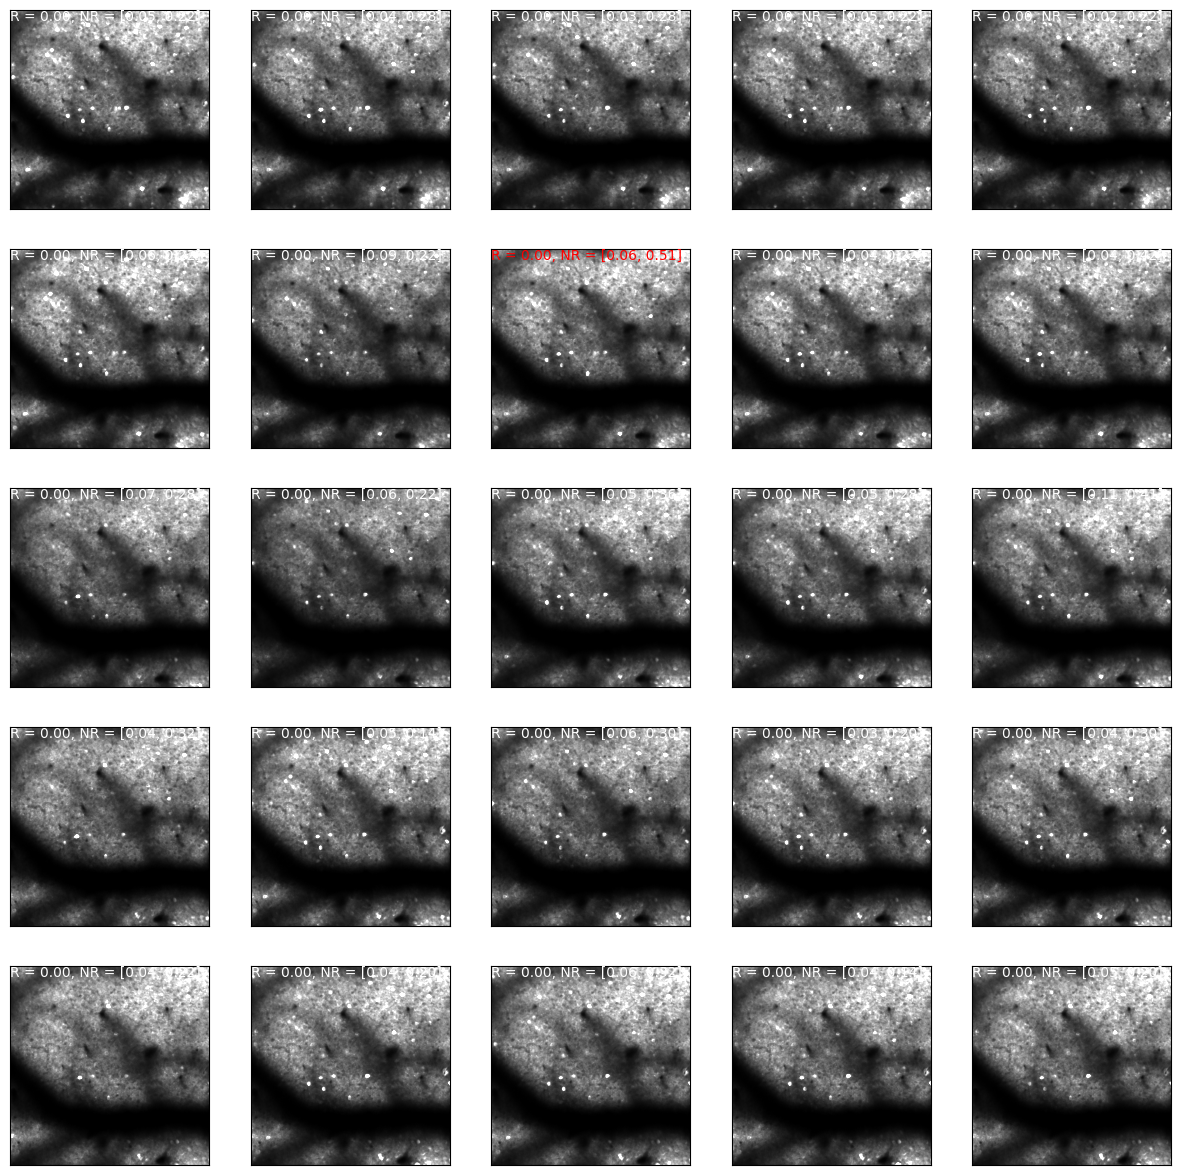

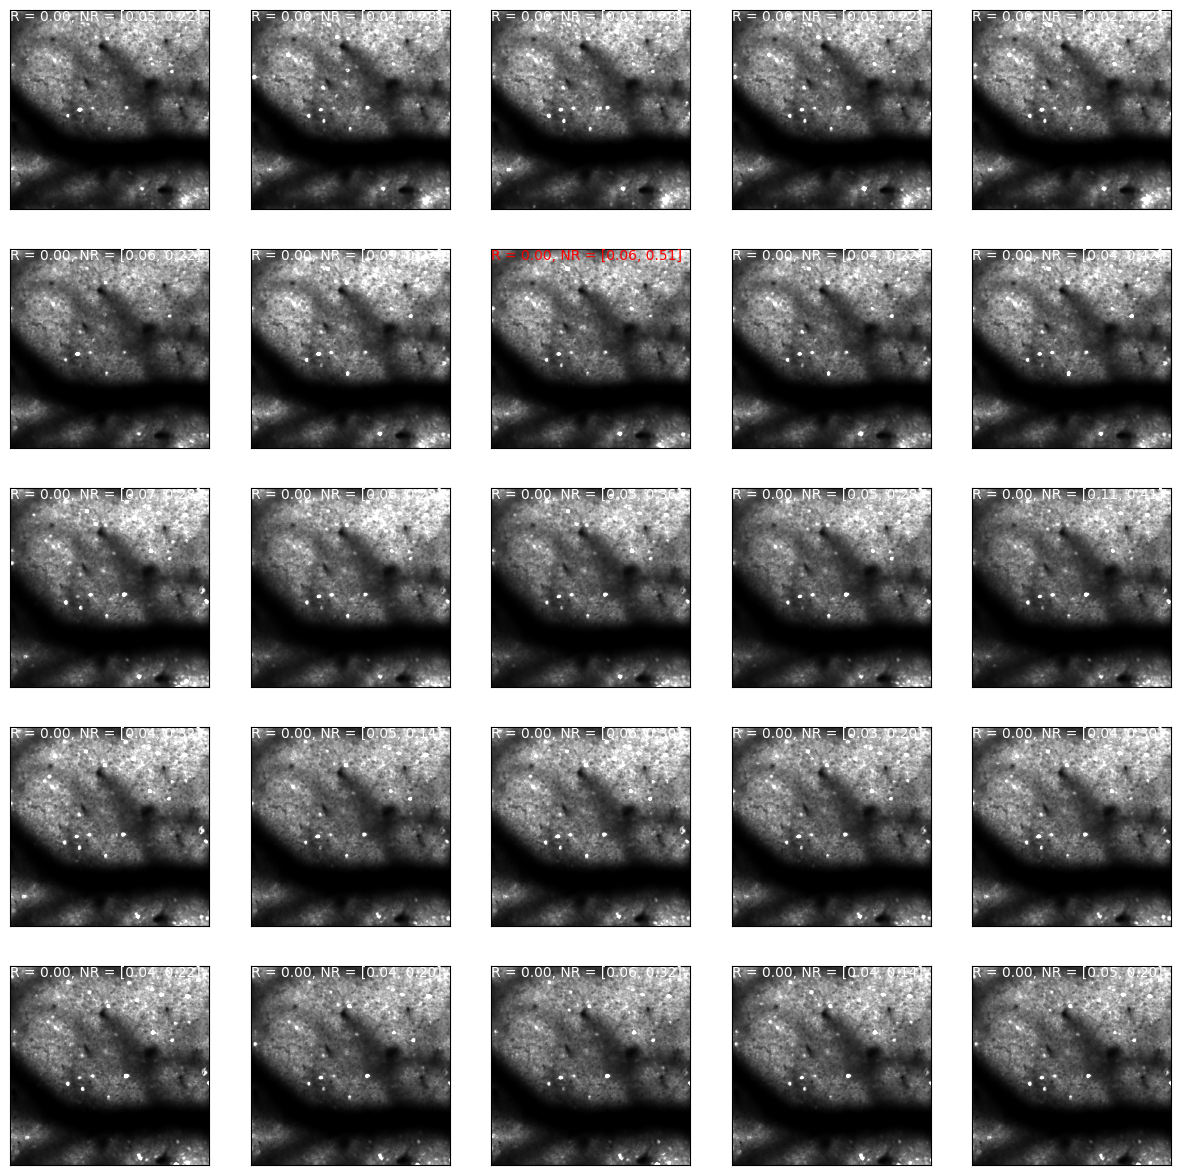

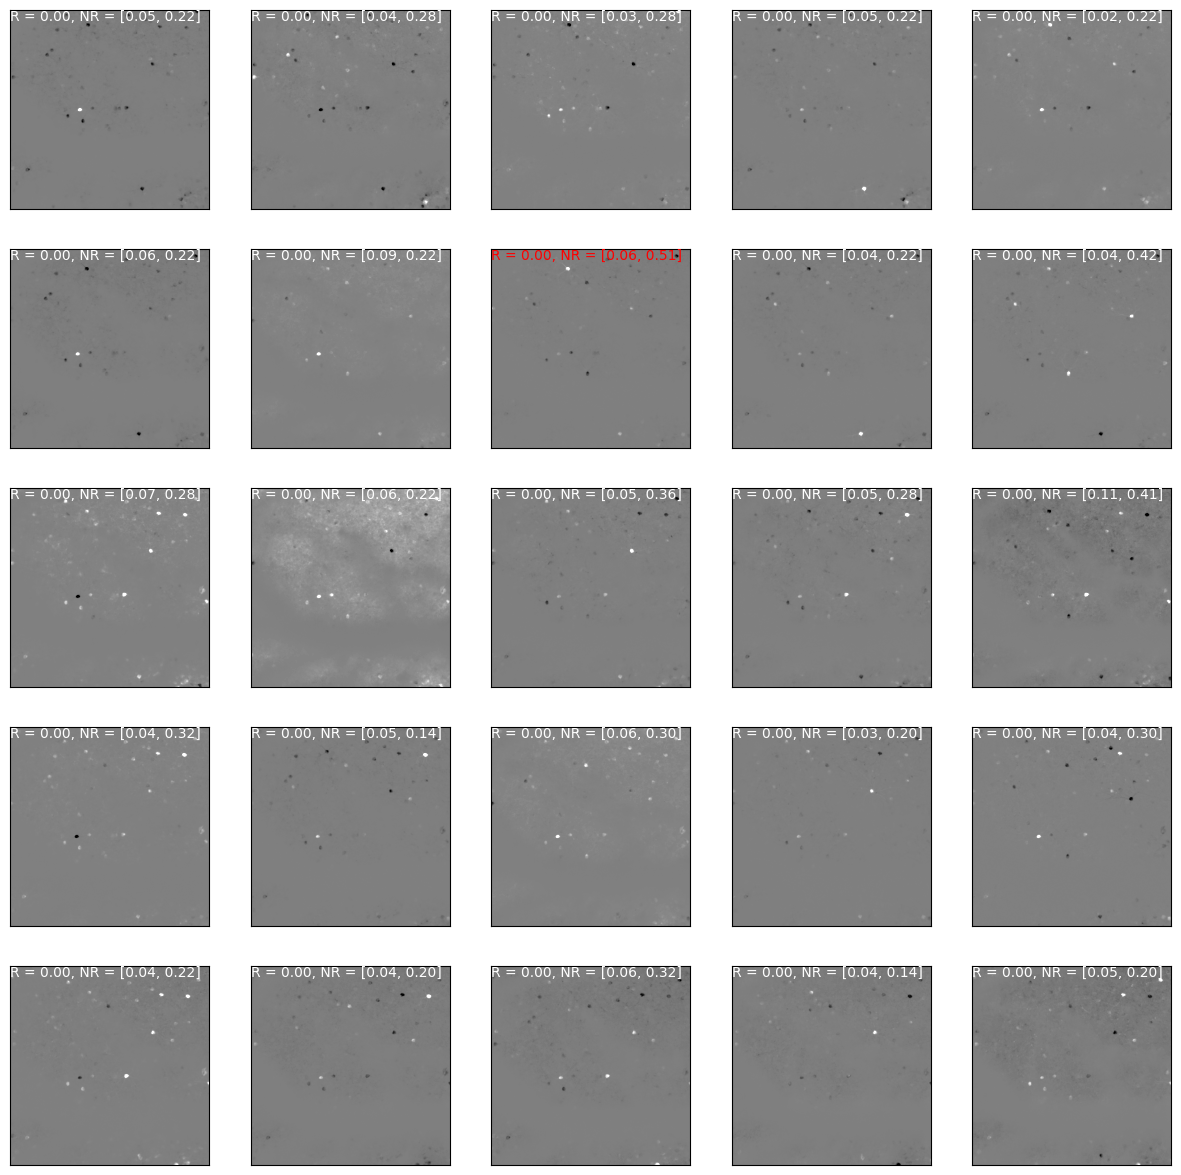

In [104]:
paths = paths_allOps[10:15] #sub-selection if necessary
plots  = ['lo','hi','diff']
crop_bounds = [0,490]
ff = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject+'/reg_metrics').resolve()
for ii,p in enumerate(plots):
    fig, axs = plt.subplots(len(paths),5,figsize=(15,3*len(paths)))
    for i,path in enumerate(paths):
        ops = np.load(path, allow_pickle=True).item()
        reg_metrics_avg = np.mean(ops['regDX'],axis=0)
        reg_metrics_max = np.max(ops['regDX'],axis=0)
        reg_shifts = np.sqrt(np.square(ops['yoff'])+np.square(ops['xoff']))
        reg_shift_avg = np.mean(reg_shifts[~ops['badframes']])
        reg_shift_max = np.amax(reg_shifts[~ops['badframes']])
        for j in range(5):
            #make image
            if ii==2:
                im = np.squeeze(np.diff(ops['regPC'],axis=0))[j][crop_bounds[0]:crop_bounds[1],crop_bounds[0]:crop_bounds[1]]
                axs[i,j].imshow(im, vmin=-0.5*np.amax(abs(im)), vmax=np.amax(0.5*abs(im)), cmap='gray')
            else:
                im = np.squeeze(ops['regPC'][ii])[j][crop_bounds[0]:crop_bounds[1],crop_bounds[0]:crop_bounds[1]]
                axs[i,j].imshow(im, vmin=np.percentile(ops['regPC'][:,j],5), vmax=np.percentile(ops['regPC'][:,j],99), cmap='gray')
            #add text
            txt_r_mean = '%.2f' %ops['regDX'][j][0]
            txt_nr_mean = '%.2f' %ops['regDX'][j][1]
            txt_nr_max = '%.2f' %ops['regDX'][j][2]
            t = 'R = ' + txt_r_mean + ', NR = [' + txt_nr_mean + ', ' + txt_nr_max + ']'
            if np.any(ops['regDX'][j]>0.5):
                axs[i,j].text(0,0,t,color=[1,0,0],va='top')
            else:
                axs[i,j].text(0,0,t,color=[1,1,1],va='top')
            #remove ticks
            axs[i,j].tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
            
    plt.savefig(ff / (fov_name + '_reg_metrics_sel_full_' + p + '.svg'),bbox_inches='tight')

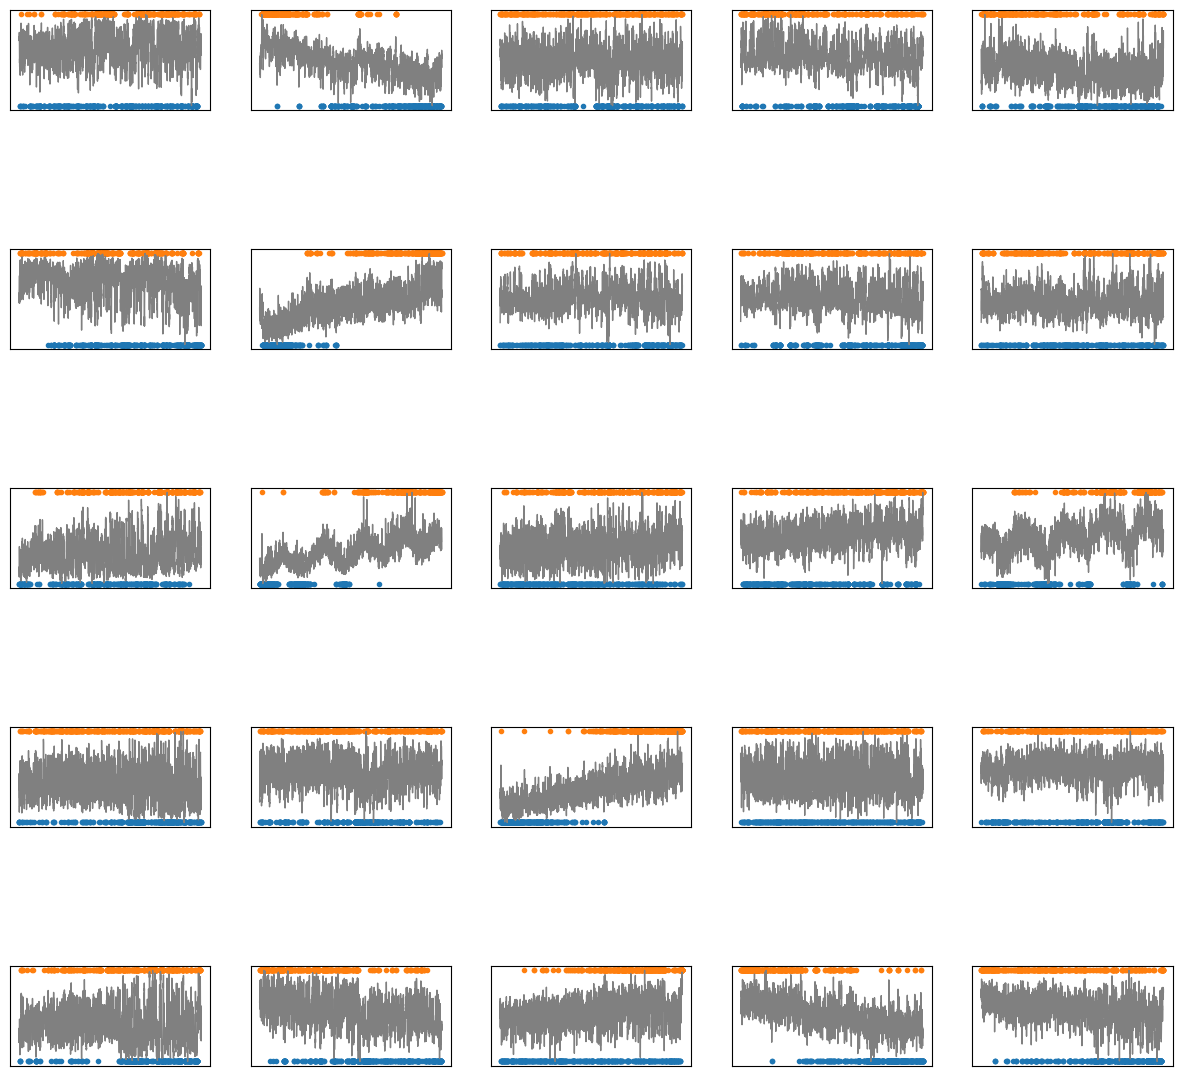

In [100]:
#check PC time-course
#paths = paths_allOps[15:20] #sub-selection if necessary
plots  = ['tPC']
ff = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject+'/reg_metrics').resolve()
for ii,p in enumerate(plots):
    fig, axs = plt.subplots(len(paths),5,figsize=(15,3*len(paths)))
    for i,path in enumerate(paths):
        ops = np.load(path, allow_pickle=True).item()
        reg_tPC = ops['tPC']
        for j in range(5):
            top_500_idx = np.argsort(reg_tPC[:,j])[-500:]
            bottom_500_idx = np.argsort(reg_tPC[:,j])[:500]
            #make plot
            axs[i,j].plot(reg_tPC[:,j],color=[.5,.5,.5],linewidth=1)
            axs[i,j].scatter(bottom_500_idx,np.repeat(np.min(reg_tPC[:,j]),500),marker='.')
            axs[i,j].scatter(top_500_idx,np.repeat(np.max(reg_tPC[:,j]),500),marker='.')
            axs[i,j].set_box_aspect(0.5)
            #add text
            #txt_r_mean = '%.2f' %ops['regDX'][j][0]
            #txt_nr_mean = '%.2f' %ops['regDX'][j][1]
            #txt_nr_max = '%.2f' %ops['regDX'][j][2]
            #t = 'R = ' + txt_r_mean + ', NR = [' + txt_nr_mean + ', ' + txt_nr_max + ']'
            #if np.any(ops['regDX'][j]>0.5):
            #    axs[i,j].text(0,0,t,color=[1,0,0],va='top')
            #else:
            #    axs[i,j].text(0,0,t,color=[1,1,1],va='top')
            #remove ticks
            axs[i,j].tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
            
    plt.savefig(ff / (fov_name + '_tPC_sel_' + p + '.svg'),bbox_inches='tight')

In [91]:
np.shape(ops['tPC'])

(5000, 30)

In [82]:
#check registration metrics in ops files
for i,path in enumerate(paths_allOps):
    ops = np.load(path, allow_pickle=True).item()
    reg_metrics_avg = np.mean(ops['regDX'],axis=0)
    reg_metrics_max = np.max(ops['regDX'],axis=0)
    #reg_dx_nonrigid_range = [np.amin(ops_dict['xoff1']) np.amax(ops_dict['xoff1'])]
    reg_shifts = np.sqrt(np.square(ops['yoff'])+np.square(ops['xoff']))
    reg_shift_avg = np.mean(reg_shifts[~ops['badframes']])
    reg_shift_max = np.amax(reg_shifts[~ops['badframes']])
    print(str(path) + ' reg_metrics_avg: ' + str(reg_metrics_avg[1:]) + ' reg_metrics_max: ' + str(reg_metrics_max[1:]) + ' reg_shift: ' + str([reg_shift_avg,reg_shift_max]))
    #print(ops['maxregshift'])

#TO DO: verify that suite2p excludes badframes when computing regDX & regDY
#TO DO: check the size of the maximum phase correlation in ops['corrXY']

\\128.40.198.163\ibldata\Subjects\SP058\2024-06-18\002\alf\FOV_04\_suite2p_ROIData.raw\ops.npy reg_metrics_avg: [0.03816901 0.30071014] reg_metrics_max: [0.05064819 0.50990194] reg_shift: [2.2167305265766166, 6.082762530298219]
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-19\001\alf\FOV_04\_suite2p_ROIData.raw\ops.npy reg_metrics_avg: [0.04390281 0.20175427] reg_metrics_max: [0.08808903 0.31622776] reg_shift: [4.534618395802656, 13.038404810405298]
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-20\001\alf\FOV_04\_suite2p_ROIData.raw\ops.npy reg_metrics_avg: [0.03703575 0.22232066] reg_metrics_max: [0.07402099 0.31622776] reg_shift: [6.111684180258842, 12.083045973594572]
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-21\001\alf\FOV_04\_suite2p_ROIData.raw\ops.npy reg_metrics_avg: [0.03849651 0.19445939] reg_metrics_max: [0.06015793 0.30000001] reg_shift: [3.415649356956833, 10.0]
\\128.40.198.163\ibldata\Subjects\SP058\2024-06-25\001\alf\FOV_04\_suite2p_ROIData.raw\ops.npy reg_met

In [105]:
#Miles' code for searching through all ops files
from one.alf.io import iter_sessions
import numpy as np
from pathlib import Path
#root_dir = Path('/mnt/s0/Data/Subjects/')
root_dir = Path('Y:/Subjects/')
# root_dir = one.cache_dir / 'cortexlab' / 'Subjects'
all_pars = {}  # a map of sessions to FOV to registration pars
for session_path in iter_sessions(root_dir, pattern='*/????-??-??/*'):
    session = '/'.join(session_path.parts[-3:])
    pars = {}
    for file in session_path.glob('alf/FOV_??/_suite2p_ROIData.raw.zip'):
        try:
            s2pdata = np.load(file, allow_pickle=True)  # lazy load from zip
            ops = s2pdata['ops'].item()
            reg_metrics_avg = np.mean(ops['regDX'], axis=0)
            reg_metrics_max = np.max(ops['regDX'], axis=0)
            fov = file.parts[-2]
            pars[fov] = (reg_metrics_avg, reg_metrics_max)
        except Exception as ex:
            pass
    if pars:
        all_pars[session] = pars

ModuleNotFoundError: No module named 'one'